In [1]:
import numpy as np
import time
import Robot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from MyRobotMath import SE3, quintic_time_scaling

scara = Robot.SCARA(2,1,1)
wam = Robot.BarretWAM(55,30,6,4.5)
se3 = SE3()
# M = scara.zero
# S = scara.S_tw
# B = scara.B_tw
M = wam.zero
S = wam.S_tw
B = wam.B_tw
N = len(wam.joint)

In [13]:
desired = [25.5,10,55,45,-45,-45] # 목표 자세의 (x,y,z,roll,pitch,yaw)
T_d = se3.pose_to_SE3(desired) # 목표 자세의 Tranformation Matrix
threshold = 1e-6 # 오차 범위
count = 0

init = Robot.select_init(desired, wam.preset) 

while True:

    matexps_b = []
    matexps_s = []

    count += 1 # 연산 횟수 증가

    for i in range(N):
        matexps_b.append(se3.matexp(wam.joint[i],init[i],B[i])) # Body Axis 기준 각 축의 Matrix Exponential
        matexps_s.append(se3.matexp(wam.joint[i],init[i],S[i])) # Space Axis 기준 각 축의 Matrix Exponential

    T_sb = se3.matsb(M,matexps_b) # Forward Kinematics 적용 변환행렬
    estimated = []
    for i in range(3):
        estimated.append(T_sb[i,3].item()) # 현재 x, y, z
    
    eulerAngles = se3.CurrenntAxis(T_sb)
    for eulerAngle in eulerAngles:
        estimated.append(eulerAngle) # Euler 각도 추정값

    pos_err = np.array(desired[:3]) - np.array(estimated[:3]) # x, y, z 오차

    T_bd = np.dot(np.linalg.inv(T_sb),T_d) # Relative Trasformation Matrix
    J_b = se3.body_jacobian(M,matexps_b,matexps_s,S) # Body Jacobian
    J_pseudo = se3.j_inv(J_b) # Jacobian의 역행렬 (또는 의사역행렬)
    V_bd, theta_err = se3.relativetwist(T_bd) # Ralative Twist, 각도 오차

    theta = Robot.deg2rad(init,wam.joint)
    thetak = theta.reshape(N,1) + J_pseudo @ V_bd.reshape(6,1) # Newton Raphson Method
    thetak = Robot.rad2deg(thetak,wam.joint) # radian to degree
    init = Robot.theta_normalize(thetak,wam.joint) # 각도 정규화 (-180~180)

    if np.all(np.abs(pos_err) < threshold) and np.abs(theta_err) < threshold: # 오차가 임계값 이내면 break
        print(estimated)
        print(f"연산 횟수 : {count}, Joint Value : {init}")
        print(T_bd)
        print(theta_err)
        break

[25.500000000000014, 9.999999999999998, 54.999999999999986, 44.99999999997942, -44.999999999999446, -45.00000000001118]
연산 횟수 : 13, Joint Value : [71.64107789888503, 13.255834087644077, 110.8760634539086, -80.35149370459192, 51.127561780621114, 134.19152207260194, 126.29475835597016]
[[ 1.00000000e+00  5.89237534e-14  1.72828221e-13 -1.02140518e-14]
 [-5.89590079e-14  1.00000000e+00 -1.86453828e-13  7.10542736e-15]
 [-1.72752841e-13  1.86584718e-13  1.00000000e+00  1.86517468e-14]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
2.1073424255447017e-08


In [ ]:
theta_start = np.array([135,45,0,0.2])
theta_end = np.array(init)
print(theta_start,theta_end)

[135.   45.    0.    0.2] [ 66.01607976 -72.54239693  51.52631717   1.2       ]


In [ ]:
T = 4.0
N = 200

trajectory = []
velocity = []
accelation = []

for i in range(N):
    t = i / N * T
    s, s_dot, s_ddot = quintic_time_scaling(t, T)
    theta_desired = theta_start + s*(theta_end-theta_start)
    theta_dot = s_dot*(theta_end-theta_start)
    theta_ddot = s_ddot*(theta_end-theta_start)
    trajectory.append(theta_desired)
    velocity.append(theta_dot)
    accelation.append(theta_ddot)

trajectory = np.array(trajectory).T  # shape = (4, N)
velocity = np.array(velocity).T
accelation = np.array(accelation).T

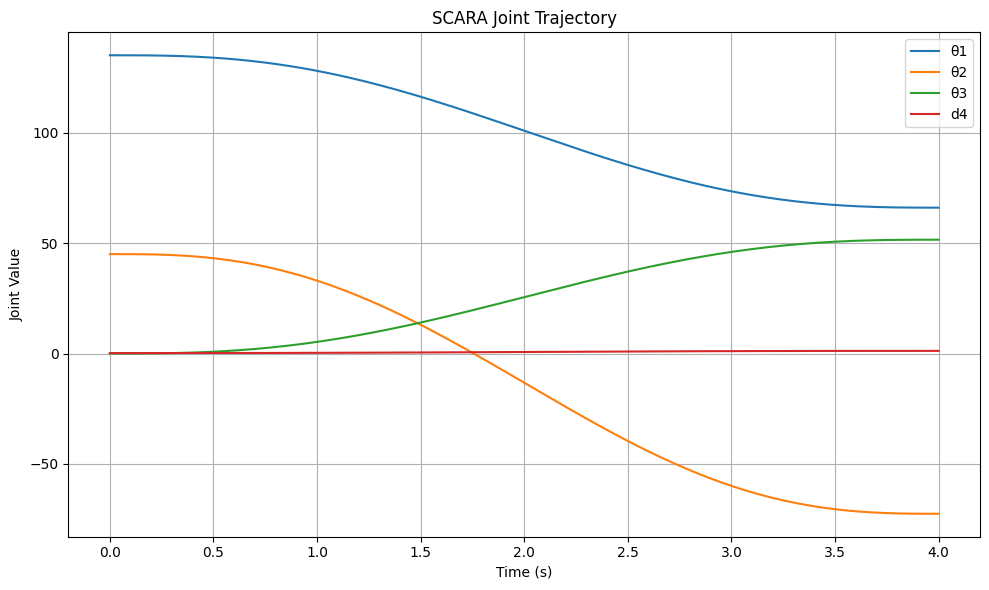

In [ ]:
plt.figure(figsize=(10, 6))
for i, joint in enumerate(["θ1", "θ2", "θ3", "d4"]):
    plt.plot(np.linspace(0, T, N), trajectory[i], label=joint)

plt.xlabel("Time (s)")
plt.ylabel("Joint Value")
plt.title("SCARA Joint Trajectory")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

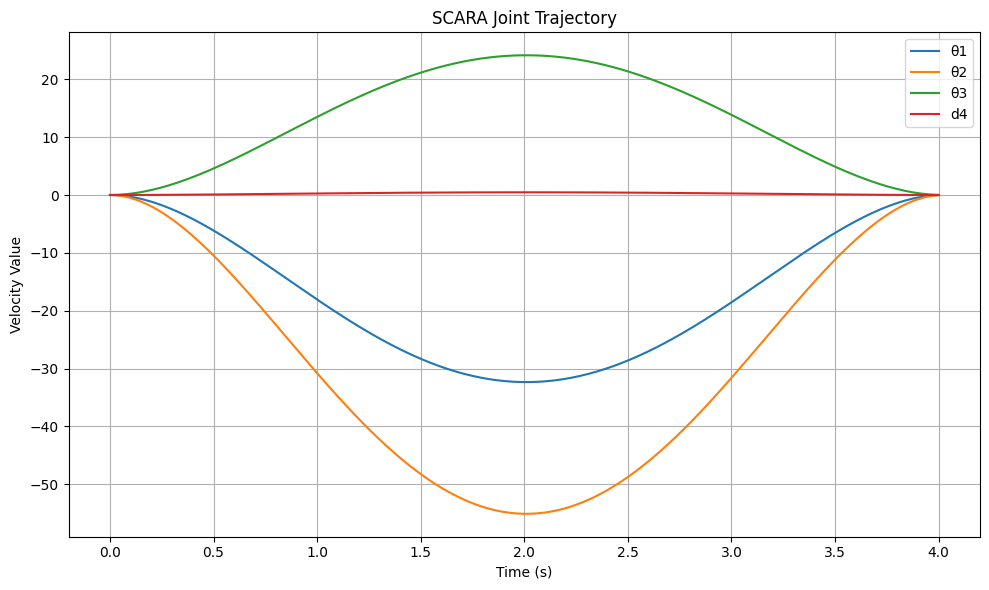

In [ ]:
plt.figure(figsize=(10, 6))
for i, joint in enumerate(["θ1", "θ2", "θ3", "d4"]):
    plt.plot(np.linspace(0, T, N), velocity[i], label=joint)

plt.xlabel("Time (s)")
plt.ylabel("Velocity Value")
plt.title("SCARA Joint Trajectory")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

